<font color="#e32b3d"><h1>Intent Classification</h2></font>

<font color="#822b34"><h2>*TREC Dataset*</h2></font>
<font color="#2ff9b3d"><h1>Part 1: First Model - Main class classification</h1></font>

required library and packages are imported.

In [65]:
# Import library
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import spatial
from tqdm import tqdm
from PIL import Image
import cv2
import glob
import os

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
DIR_TRAIN = "/content/drive/MyDrive/TREC Dataset/train.csv"
DIR_TEST = "/content/drive/MyDrive/TREC Dataset/test.csv"

In [68]:
train_df = pd.read_csv(DIR_TRAIN)
test_df = pd.read_csv(DIR_TEST)
print('Train data set : '+str(train_df.shape[0]))
print('Test data set : '+str(test_df.shape[0]))

Train data set : 5452
Test data set : 500


In [69]:
coarse_classes = len(set(train_df["label-coarse"]))

coarse_labels=[]
for i in range(coarse_classes):
  coarse_labels.append(i) 

class_names = ['abbreviaion', 'entity', 'description', 'human', 'location', 'numeric']
print('Coarse labels : '+str(coarse_classes))

Coarse labels : 6


In [70]:
from torchtext.vocab import GloVe
global_vectors = GloVe(name='6B', dim=300)
global_vectors

In [71]:
## tensor with size (1,300) with all zero elements for padding
colm_zero = torch.tensor([0 for i in range(300)]).to('cuda')

*tokenized* function to tokenize each sequence

In [72]:
from torchtext.data.utils import get_tokenizer
class tokenized ():
  def __init__(self, data):
    self.text = data[2]
    self.C_label = data[0]
    self.F_label = data[1]

  def Q_normalize (self):
    tokenizer = get_tokenizer("basic_english")
    lower = self.text.lower()
    ripped = lower.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'))
    token = tokenizer(ripped)
    return token, self.C_label, self.F_label
  

*vectorized* function to convert each word in a sequence to its corresponding tensor from *glove* dictionary

In [73]:
class vectorized ():
  def __init__(self, tokenized_Q):
    self.length = len(tokenized_Q)
    self.tokenized_Q = tokenized_Q
    self.l = []
    self.t = torch.empty((self.length,300), dtype=torch.float32)
  
  def data(self):
    for i in range(self.length):
      try: 
        idx = global_vectors.itos.index(self.tokenized_Q[i])
        self.l.append(global_vectors.vectors[idx].to('cuda'))
        self.t[i] = global_vectors.vectors[idx].to('cuda')
      except:
        ## if the word is not in the dictionary use paddings instead
        self.t[i] =colm_zero
        # print("the requested word is not in the dictionary")
        continue
    return self.t


Defining our own data structure, each train data will have the following structure:

        * 'coarse_label' : (1,6) tensor indicating the coarse label in a one hot manner
        * 'fine_label' : (1,47) tensor indicating the fine label in a one hot manner
        * 'data' : (seq_len, 300) tensor of converted sequence

In [74]:
## creating train the dataset 
train_dataset = []
for i in range(train_df.shape[0]):
  ## empty tensor for one hot label
  target = torch.empty((coarse_classes), dtype=torch.float32).to('cuda')
  tewt, CL, FL = tokenized(train_df.values[i]).Q_normalize()
  data = vectorized(tewt).data().to('cuda')
  for i in range(coarse_classes):
    if (i == CL):
      target[i] = torch.tensor([1]).to('cuda')
    else: 
      target[i] = torch.tensor([0]).to('cuda')
  m = {'target': target,
      'data':data}
  train_dataset.append(m)


In [75]:
## creating validation the dataset 
test_dataset = []
for i in range(test_df.shape[0]):
  target = torch.empty((coarse_classes), dtype=torch.float32).to('cuda')
  tewt, CL, FL = tokenized(train_df.values[i]).Q_normalize()
  data = vectorized(tewt).data().to('cuda')
  for i in range(coarse_classes):
    if (i == CL):
      target[i] = torch.tensor([1]).to('cuda')
    else: 
      target[i] = torch.tensor([0]).to('cuda')
  m = {'target': target,
      'data':data}
  test_dataset.append(m)

Samples of dataset:

In [76]:
train_dataset[4]

{'target': tensor([0., 0., 1., 0., 0., 0.], device='cuda:0'),
 'data': tensor([[-0.2002,  0.1430,  0.0521,  ...,  0.0349, -0.1260,  0.2186],
         [-0.1749,  0.2296,  0.2492,  ..., -0.2413, -0.4040,  0.0547],
         [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
         ...,
         [-0.0769, -0.0212,  0.2127,  ...,  0.1835, -0.2918, -0.0465],
         [ 0.0391,  0.3460,  0.1155,  ..., -0.2009,  0.3085, -0.2755],
         [-0.0833, -0.2090, -0.0436,  ..., -0.1775,  0.0558,  0.8013]],
        device='cuda:0')}

Finding the maximum sequence length:

In [77]:
# maximum sentence length in train dataset
length =[]
for i in range(train_df.shape[0]):
  length.append(train_dataset[i]["data"].shape[0])
max_len = max(length)
max_len

34

padding each sequence so that all the suqences have the matching length of *max_len*


In [78]:
# padding with zero tensors
for i in range(train_df.shape[0]):
  if(train_dataset[i]['data'].shape[0]<=max_len):
    temp = torch.empty((max_len-train_dataset[i]['data'].shape[0],300), dtype=torch.int64).to('cuda')
    for k in range(max_len-train_dataset[i]['data'].shape[0]):
      temp[k] = colm_zero
    train_dataset[i]['data'] = torch.cat((temp, train_dataset[i]['data']), 0)


for i in range(test_df.shape[0]):
  if(test_dataset[i]['data'].shape[0]<=max_len):
    temp = torch.empty((max_len-test_dataset[i]['data'].shape[0],300), dtype=torch.int64).to('cuda')
    for k in range(max_len-test_dataset[i]['data'].shape[0]):
      temp[k] = colm_zero
    test_dataset[i]['data'] = torch.cat((temp, test_dataset[i]['data']), 0)

checking the length of sequencs in both datasets:

In [79]:
## sample of train padded data
print(train_dataset[2661]['data'].shape)
## sample of validation padded data
print(test_dataset[2]['data'].shape)

torch.Size([34, 300])
torch.Size([34, 300])


Creating dataloaders:

In [80]:
## creating dataloaders
batch_size = 4
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size =batch_size,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size =batch_size,
    shuffle = True
)

In [81]:
class LSTM(nn.Module):

    def __init__(self, dimension):
        super(LSTM, self).__init__()
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True)
        self.dropout1 = nn.Dropout(p=0.3)
        self.sigmoid = nn.Sigmoid()
        self.coarse_linear = nn.Linear(dimension, coarse_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, text):
        out, (hidden_state,cell_state) = self.lstm(text)

        coarse = self.sigmoid(out[:, -1, :])
        coarse = self.coarse_linear(coarse)
        coarse_soft = self.softmax(coarse)
        
        return coarse_soft


Definfing the accuracy function:

In [82]:
def accuracy_fn(true, pred):
  acc = 0.0000
  for i in range(true.shape[0]):
    if (true[i].detach().cpu().numpy().argmax() == pred[i].detach().cpu().numpy().argmax()):
      acc+=1
    else:
      acc+=0
  return acc/true.shape[0]

Fit function will be called at each epoch:

In [83]:
def fit(model, train_dataloader, optimizer, criterion):
    model.train()   # Training mode (allow weight updates)
    train_running_loss = 0.0
    train_running_acc = 0.0
    counter = 0
    train_loss = 0.0
    train_acc = 0.0

    with tqdm(train_dataloader, desc ="  train") as train_tqdm:
      for item in train_tqdm:
        counter += 1
        data = item['data'].to('cuda')
        target = item['target'].to('cuda')

        optimizer.zero_grad()   # Reset gradients
        outputs = model(data.to('cuda'))   # Calculate outputs using the model

        loss = criterion(outputs, target)     ## Calculate Loss

        acc = accuracy_fn(target, outputs)
        train_running_acc += acc

        train_running_loss += loss.item()
        loss.backward()   ## Backpropage the loss and calculate the gradients
        optimizer.step()  ## Update the weights using backpropagation
        train_tqdm.set_postfix(train_acc="{:.3f}".format(train_running_acc/counter),
                               train_loss=train_running_loss/counter, refresh=False)
          
    train_loss = train_running_loss / counter ## Total epoch loss
    train_acc = train_running_acc / counter ## Total epoch acc
    return train_loss, train_acc

In [84]:
def validation(model, data_loader, criterion):
    model.eval()    ## Evaluation mode (do not allow weight updates)
    val_running_loss = 0.0
    val_running_acc = 0.0
    counter = 0
    val_loss = 0.0
    val_acc = 0.0

    with tqdm(data_loader, desc ="  test") as test_tqdm:
      for item in test_tqdm:
        counter += 1
        data = item['data'].to('cuda')
        target = item['target'].to('cuda')

        outputs = model(data.to('cuda'))   # Calculate outputs using the model

        loss = criterion(outputs, target)     ## Calculate Loss

        acc = accuracy_fn(target, outputs)
        val_running_acc += acc
        val_running_loss += loss.item()
        test_tqdm.set_postfix(train_acc="{:.3f}".format(val_running_acc/counter),
                              val_loss=val_running_loss/counter, refresh=False)

        
    val_loss = val_running_loss / counter ## Total epoch loss
    val_acc = val_running_acc / counter ## Total epoch acc
    return val_loss, val_acc

<font color="#AF3B54"><h2>*Training with 25 hidden layes*</h2></font>


Training with 25 hidden layers for 100 epochs:

In [94]:
import torch.optim as optim
model25 = LSTM(dimension=25).to('cuda')

## Optimizer and loss function
optimizer = optim.Adam(model25.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_acc = []
val_loss = []
val_acc = []
epochs = 50

for epoch in range(epochs):
  print("EPOCH {}/{} :".format(epoch +1, epochs))
  ## fit
  train_epoch_loss , train_acc_epoch= fit(model25, train_dataloader, optimizer, criterion)
  train_loss.append(train_epoch_loss)
  train_acc.append(train_acc_epoch)
  ## Validation
  val_epoch_loss , val_acc_epoch= validation(model25, test_dataloader, criterion)
  val_loss.append(val_epoch_loss)
  val_acc.append(val_acc_epoch)

torch.save(model25.state_dict(), 'first_trained_model_25')

EPOCH 1/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 660.43it/s, train_acc=0.274, val_loss=1.76]


EPOCH 2/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 783.23it/s, train_acc=0.464, val_loss=1.73]


EPOCH 3/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 840.20it/s, train_acc=0.462, val_loss=1.69]


EPOCH 4/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 661.05it/s, train_acc=0.448, val_loss=1.66]


EPOCH 5/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 867.32it/s, train_acc=0.480, val_loss=1.63]


EPOCH 6/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 849.15it/s, train_acc=0.532, val_loss=1.61]


EPOCH 7/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 601.84it/s, train_acc=0.552, val_loss=1.59]


EPOCH 8/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 837.52it/s, train_acc=0.570, val_loss=1.57]


EPOCH 9/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 867.07it/s, train_acc=0.578, val_loss=1.55]


EPOCH 10/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 841.24it/s, train_acc=0.588, val_loss=1.53]


EPOCH 11/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 844.79it/s, train_acc=0.582, val_loss=1.52]


EPOCH 12/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 848.32it/s, train_acc=0.598, val_loss=1.5]


EPOCH 13/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 813.67it/s, train_acc=0.590, val_loss=1.49]


EPOCH 14/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 596.74it/s, train_acc=0.618, val_loss=1.46]


EPOCH 15/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 849.15it/s, train_acc=0.680, val_loss=1.46]


EPOCH 16/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 850.36it/s, train_acc=0.706, val_loss=1.43]


EPOCH 17/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 643.08it/s, train_acc=0.700, val_loss=1.41]


EPOCH 18/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 851.40it/s, train_acc=0.718, val_loss=1.41]


EPOCH 19/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 823.03it/s, train_acc=0.708, val_loss=1.39]


EPOCH 20/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 574.73it/s, train_acc=0.730, val_loss=1.37]


EPOCH 21/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 820.34it/s, train_acc=0.746, val_loss=1.36]


EPOCH 22/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 839.13it/s, train_acc=0.790, val_loss=1.35]


EPOCH 23/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 460.97it/s, train_acc=0.838, val_loss=1.33]


EPOCH 24/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 844.63it/s, train_acc=0.842, val_loss=1.32]


EPOCH 25/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 854.26it/s, train_acc=0.866, val_loss=1.31]


EPOCH 26/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 864.66it/s, train_acc=0.872, val_loss=1.29]


EPOCH 27/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 835.16it/s, train_acc=0.860, val_loss=1.3]


EPOCH 28/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 809.34it/s, train_acc=0.880, val_loss=1.27]


EPOCH 29/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 846.79it/s, train_acc=0.872, val_loss=1.27]


EPOCH 30/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 579.85it/s, train_acc=0.888, val_loss=1.25]


EPOCH 31/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 864.00it/s, train_acc=0.888, val_loss=1.24]


EPOCH 32/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 854.42it/s, train_acc=0.890, val_loss=1.23]


EPOCH 33/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 631.16it/s, train_acc=0.894, val_loss=1.22]


EPOCH 34/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 861.98it/s, train_acc=0.900, val_loss=1.21]


EPOCH 35/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 780.90it/s, train_acc=0.894, val_loss=1.21]


EPOCH 36/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 660.02it/s, train_acc=0.902, val_loss=1.2]


EPOCH 37/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 840.07it/s, train_acc=0.908, val_loss=1.19]


EPOCH 38/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 846.61it/s, train_acc=0.910, val_loss=1.18]


EPOCH 39/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 629.64it/s, train_acc=0.914, val_loss=1.18]


EPOCH 40/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 801.72it/s, train_acc=0.900, val_loss=1.18]


EPOCH 41/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 822.08it/s, train_acc=0.890, val_loss=1.18]


EPOCH 42/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 846.92it/s, train_acc=0.916, val_loss=1.17]


EPOCH 43/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 824.16it/s, train_acc=0.910, val_loss=1.17]


EPOCH 44/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 785.42it/s, train_acc=0.914, val_loss=1.16]


EPOCH 45/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 871.74it/s, train_acc=0.916, val_loss=1.16]


EPOCH 46/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 582.61it/s, train_acc=0.890, val_loss=1.18]


EPOCH 47/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 825.71it/s, train_acc=0.918, val_loss=1.15]


EPOCH 48/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 847.10it/s, train_acc=0.918, val_loss=1.15]


EPOCH 49/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 658.29it/s, train_acc=0.920, val_loss=1.15]


EPOCH 50/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 801.52it/s, train_acc=0.918, val_loss=1.15]


*plot_acc_loss* function plots accuracy and loss values for train and validation per epoch

In [95]:
import matplotlib.pyplot as plt
def plot_acc_loss(train_acc, val_acc, train_loss, val_loss, hidden, name):
  fig, axs = plt.subplots(2, figsize=(15,10))

  ## Plotting the training loss and validation loss vs epochs for each model
  axs[0].plot(list(range(1,len(train_acc)+1)), train_acc, label='Train Acc', linewidth=4)
  axs[0].plot(list(range(1,len(val_acc)+1)), val_acc, label='Val Acc', linewidth=4)
  axs[0].set_title(str(name)+' Accuracy per Epoch for First Model with hidden_layer = '+str(hidden))
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')
  axs[0].grid()
  axs[0].legend()
  ## Plotting the training loss and validation loss vs epochs for each model
  axs[1].plot(list(range(1,len(train_loss)+1)), train_loss, label='Train Loss', linewidth=4)
  axs[1].plot(list(range(1,len(val_loss)+1)), val_loss, label='Val Loss', linewidth=4)
  axs[1].set_title(str(name)+' Loss per Epoch for First Model with hidden_layer = '+str(hidden))
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Loss')
  axs[1].grid()
  axs[1].legend()
  plt.tight_layout()
   

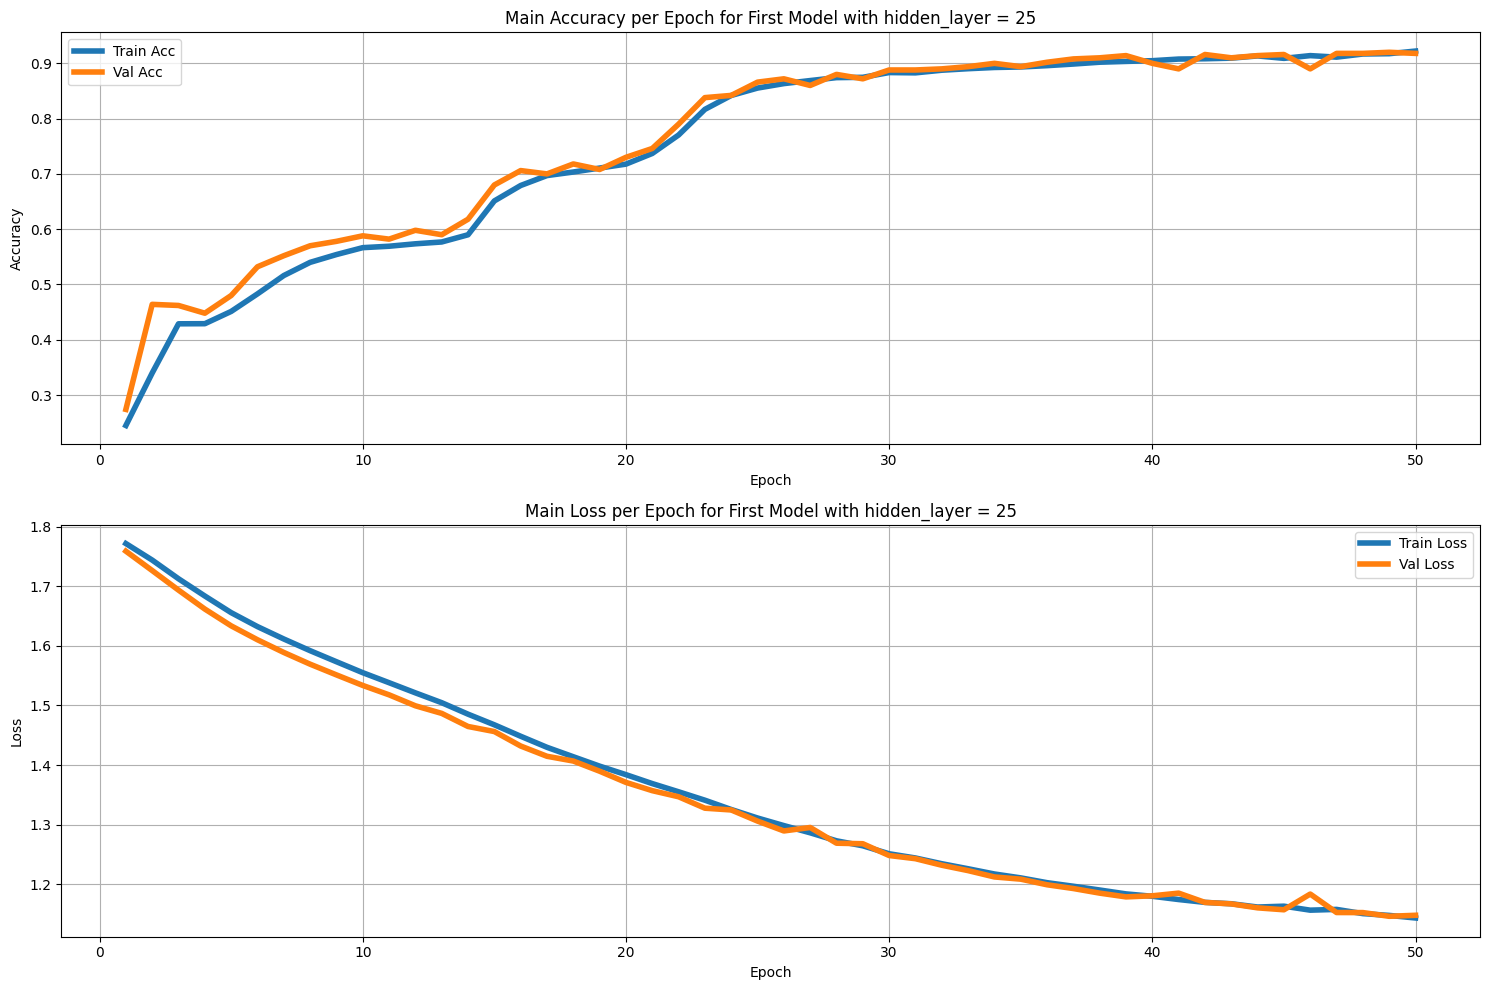

In [96]:
# Main classification
plot_acc_loss(train_acc, val_acc, train_loss, val_loss, 25, 'Main')

*conf_acc* function plots confusion matrix and reports classification metrics such as f1-score, percision, recall and accuracy

In [97]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def conf_acc(y_true, y_pred, Attr, hidden):
  cnf_matrix = confusion_matrix(y_true, y_pred)   ## Sklearn confusion matrix object
  accuracy = np.trace(cnf_matrix) / float(np.sum(cnf_matrix))
  misclass = 1 - accuracy

  fig, ax = plt.subplots(figsize=(10, 10))
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap = "Blues" ,fmt='g', xticklabels=class_names , yticklabels=class_names)
  ax.xaxis.set_label_position("bottom")
  plt.title('Confusion matrix for ' + str(Attr)+' class of first model with hidden_layer = '+str(hidden), y=1.1)
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
  plt.tight_layout()
  print(classification_report(y_true, y_pred, digits=4))


*Testing* function feeds the trained network with test_dataloader and using *conf_acc* reports the results

In [98]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def Testing(model, data_loader, hidden):

  counter = 0
  y_true = []
  y_pred = []
  # Send model to GPU
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.load_state_dict(torch.load('first_trained_model_'+str(hidden)))
  model.to(device)
  model.eval() 

  with tqdm(data_loader, desc ="   test") as test_tqdm:
    for item in test_tqdm:
      counter += 1
      data = item['data'].to('cuda')
      target = item['target'].to('cuda')

      outputs = model(data.to('cuda'))   # Calculate outputs using the model

      y_true.append((target[0].detach().cpu().numpy()).argmax()) 
      y_pred.append((outputs[0].detach().cpu().numpy()).argmax())

  ## plot coonfusion matrix
  conf_acc(y_true, y_pred, 'Main', hidden)

  return


   test: 100%|██████████| 125/125 [00:00<00:00, 1218.26it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.8000    0.8333    0.8163        24
           1     0.8235    0.8750    0.8485        32
           2     0.0000    0.0000    0.0000         3
           3     0.9615    0.9259    0.9434        27
           4     0.9444    1.0000    0.9714        17
           5     0.9545    0.9545    0.9545        22

    accuracy                         0.8880       125
   macro avg     0.7473    0.7648    0.7557       125
weighted avg     0.8686    0.8880    0.8778       125



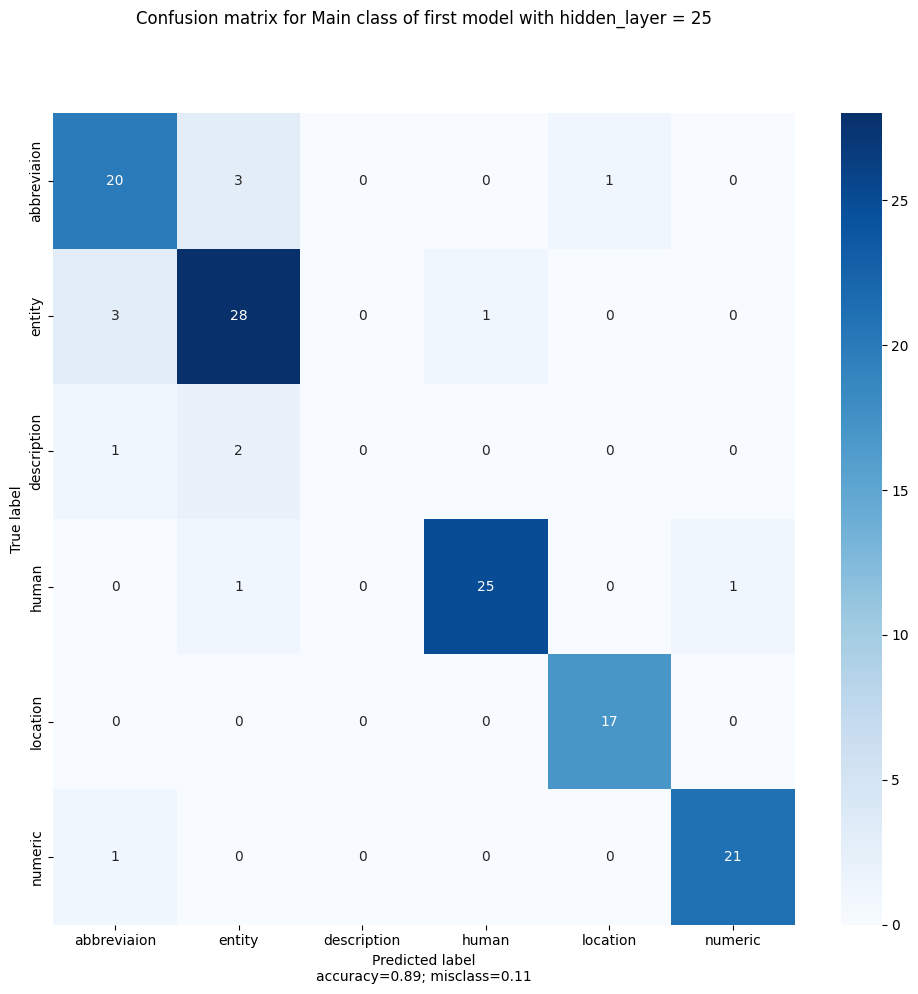

In [99]:
# testing the model with 25 hidden layers
Testing(model25, test_dataloader, 25)

<font color="#AF3B54"><h2>*Training with 100 hidden layes*</h2></font>


Training with 100 hidden layers for 50 epochs:

In [91]:
import torch.optim as optim
model100 = LSTM(dimension=100).to('cuda')

## Optimizer and loss function
optimizer = optim.Adam(model100.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_acc = []
val_loss = []
val_acc = []
epochs = 50

for epoch in range(epochs):
  print("EPOCH {}/{} :".format(epoch +1, epochs))
  ## fit
  train_epoch_loss , train_acc_epoch= fit(model100, train_dataloader, optimizer, criterion)
  train_loss.append(train_epoch_loss)
  train_acc.append(train_acc_epoch)
  ## validation
  val_epoch_loss , val_acc_epoch= validation(model100, test_dataloader, criterion)
  val_loss.append(val_epoch_loss)
  val_acc.append(val_acc_epoch)

torch.save(model100.state_dict(), 'first_trained_model_100')

EPOCH 1/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 650.41it/s, train_acc=0.472, val_loss=1.66]


EPOCH 2/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 845.78it/s, train_acc=0.546, val_loss=1.58]


EPOCH 3/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 872.03it/s, train_acc=0.564, val_loss=1.53]


EPOCH 4/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 854.26it/s, train_acc=0.580, val_loss=1.51]


EPOCH 5/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 829.37it/s, train_acc=0.586, val_loss=1.48]


EPOCH 6/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 796.00it/s, train_acc=0.632, val_loss=1.45]


EPOCH 7/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 812.49it/s, train_acc=0.714, val_loss=1.4]


EPOCH 8/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 864.61it/s, train_acc=0.718, val_loss=1.36]


EPOCH 9/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 847.01it/s, train_acc=0.726, val_loss=1.35]


EPOCH 10/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 871.09it/s, train_acc=0.728, val_loss=1.34]


EPOCH 11/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 576.14it/s, train_acc=0.742, val_loss=1.32]


EPOCH 12/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 795.14it/s, train_acc=0.740, val_loss=1.32]


EPOCH 13/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 818.71it/s, train_acc=0.744, val_loss=1.31]


EPOCH 14/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 635.75it/s, train_acc=0.754, val_loss=1.3]


EPOCH 15/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 863.32it/s, train_acc=0.752, val_loss=1.3]


EPOCH 16/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 850.58it/s, train_acc=0.766, val_loss=1.29]


EPOCH 17/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 622.39it/s, train_acc=0.764, val_loss=1.29]


EPOCH 18/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 858.59it/s, train_acc=0.752, val_loss=1.3]


EPOCH 19/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 847.42it/s, train_acc=0.778, val_loss=1.28]


EPOCH 20/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 852.14it/s, train_acc=0.772, val_loss=1.28]


EPOCH 21/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 814.46it/s, train_acc=0.782, val_loss=1.27]


EPOCH 22/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 817.59it/s, train_acc=0.782, val_loss=1.27]


EPOCH 23/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 820.34it/s, train_acc=0.782, val_loss=1.27]


EPOCH 24/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 607.68it/s, train_acc=0.820, val_loss=1.25]


EPOCH 25/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 857.42it/s, train_acc=0.868, val_loss=1.21]


EPOCH 26/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 838.97it/s, train_acc=0.884, val_loss=1.2]


EPOCH 27/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 648.62it/s, train_acc=0.898, val_loss=1.17]


EPOCH 28/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 848.65it/s, train_acc=0.900, val_loss=1.17]


EPOCH 29/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 794.90it/s, train_acc=0.904, val_loss=1.16]


EPOCH 30/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 600.28it/s, train_acc=0.914, val_loss=1.15]


EPOCH 31/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 830.91it/s, train_acc=0.926, val_loss=1.14]


EPOCH 32/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 840.06it/s, train_acc=0.924, val_loss=1.14]


EPOCH 33/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 621.80it/s, train_acc=0.922, val_loss=1.13]


EPOCH 34/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 823.62it/s, train_acc=0.926, val_loss=1.13]


EPOCH 35/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 784.07it/s, train_acc=0.930, val_loss=1.13]


EPOCH 36/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 833.32it/s, train_acc=0.928, val_loss=1.13]


EPOCH 37/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 837.80it/s, train_acc=0.916, val_loss=1.14]


EPOCH 38/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 834.50it/s, train_acc=0.930, val_loss=1.12]


EPOCH 39/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 856.09it/s, train_acc=0.932, val_loss=1.12]


EPOCH 40/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 622.95it/s, train_acc=0.932, val_loss=1.12]


EPOCH 41/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 866.58it/s, train_acc=0.936, val_loss=1.12]


EPOCH 42/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 826.06it/s, train_acc=0.932, val_loss=1.12]


EPOCH 43/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 644.19it/s, train_acc=0.936, val_loss=1.12]


EPOCH 44/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 781.39it/s, train_acc=0.938, val_loss=1.11]


EPOCH 45/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 806.65it/s, train_acc=0.934, val_loss=1.12]


EPOCH 46/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 613.98it/s, train_acc=0.936, val_loss=1.11]


EPOCH 47/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 813.26it/s, train_acc=0.928, val_loss=1.12]


EPOCH 48/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 830.83it/s, train_acc=0.936, val_loss=1.11]


EPOCH 49/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 819.30it/s, train_acc=0.936, val_loss=1.11]


EPOCH 50/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 833.23it/s, train_acc=0.936, val_loss=1.11]


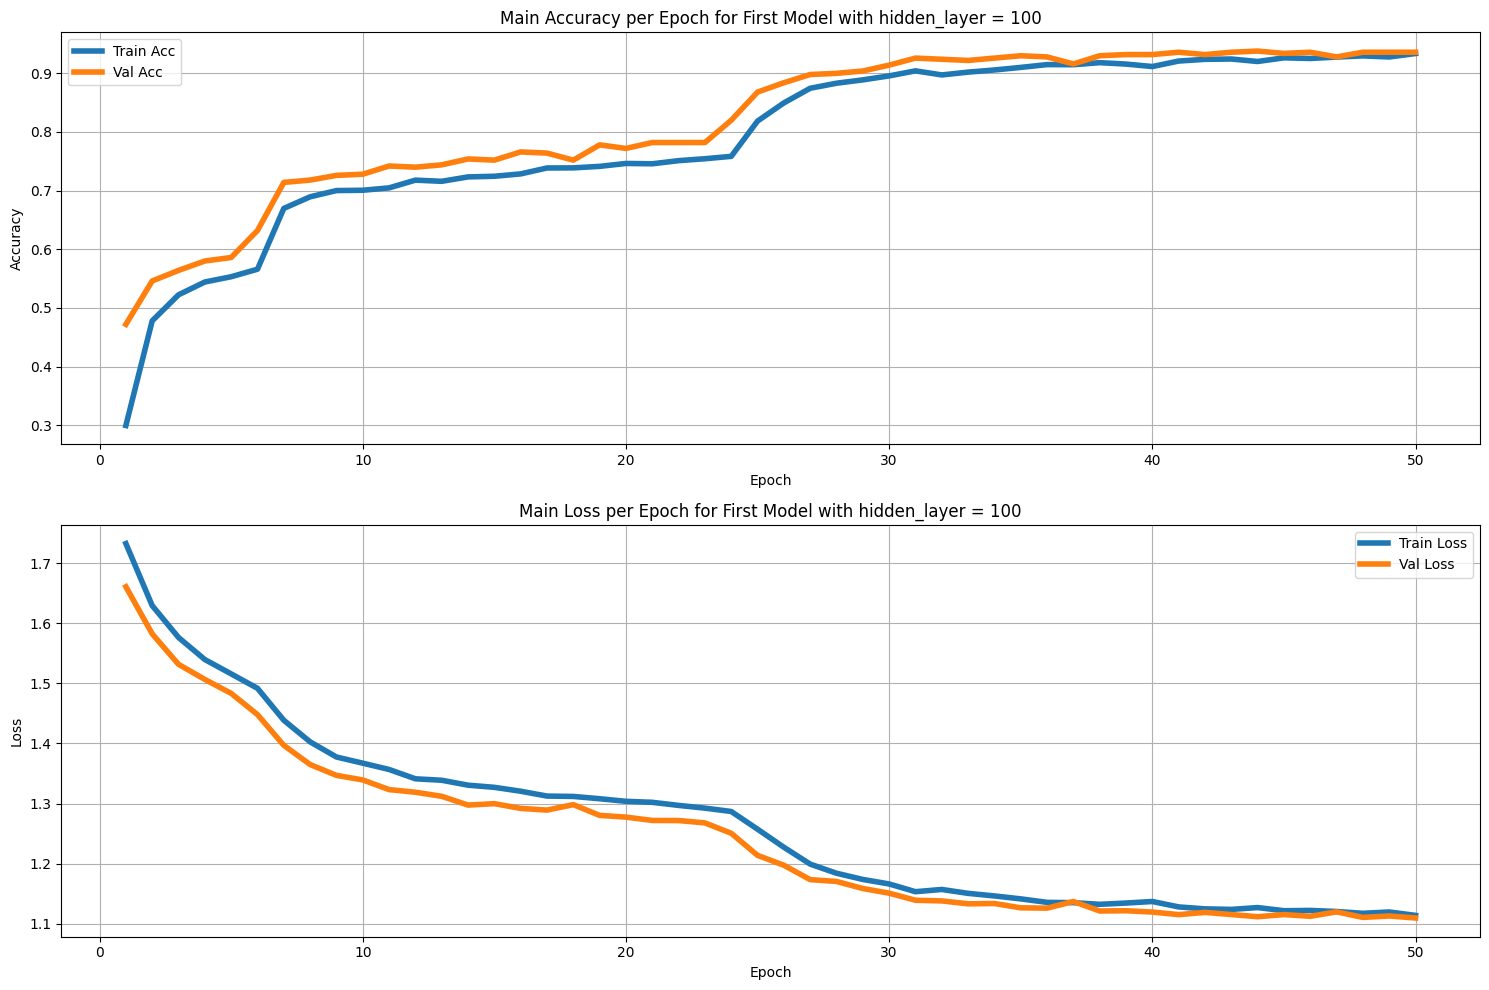

In [92]:
# Main classification
plot_acc_loss(train_acc, val_acc, train_loss, val_loss, 100, 'Main')

   test: 100%|██████████| 125/125 [00:00<00:00, 1022.58it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.9310    0.9643    0.9474        28
           1     0.8387    1.0000    0.9123        26
           2     0.0000    0.0000    0.0000         2
           3     1.0000    0.8857    0.9394        35
           4     1.0000    1.0000    1.0000        13
           5     0.9524    0.9524    0.9524        21

    accuracy                         0.9360       125
   macro avg     0.7870    0.8004    0.7919       125
weighted avg     0.9270    0.9360    0.9290       125



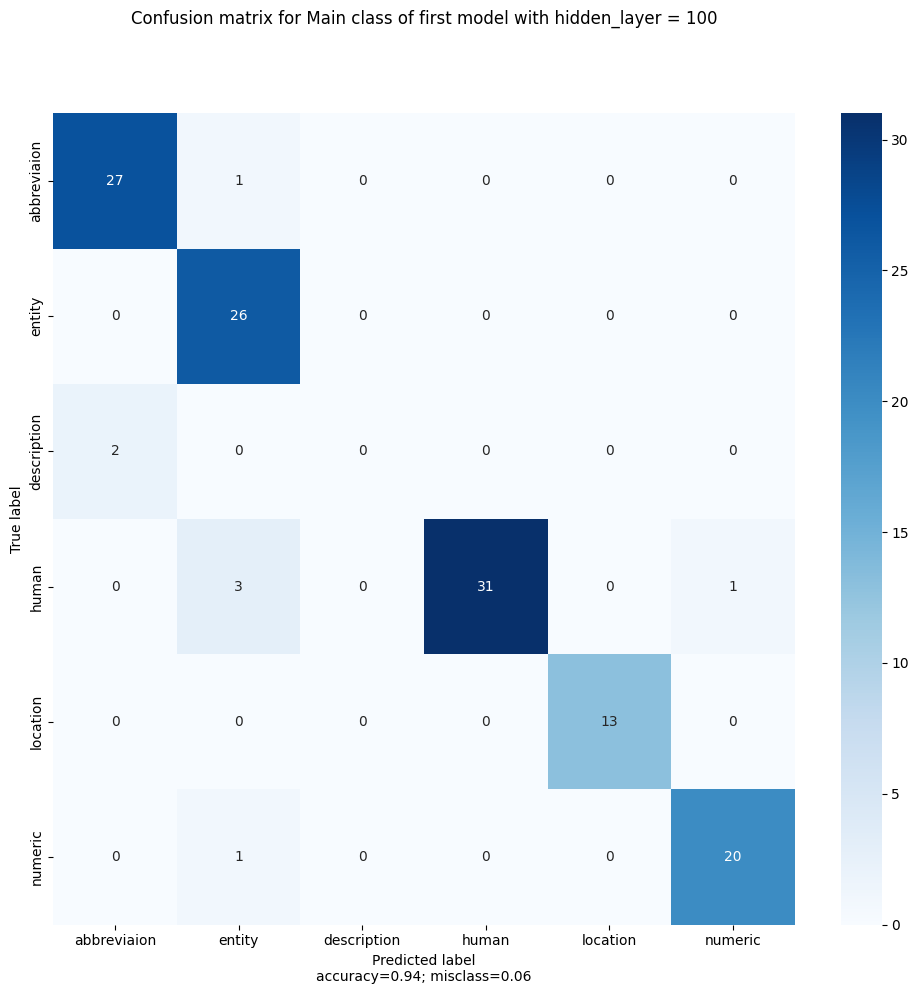

In [93]:
# testing the model with 100 hidden layers
Testing(model100, test_dataloader, 100)